In [1]:
import requests as req
import pandas as pd
import numpy as np
import json
import mysql.connector
import time
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import ensemble
from scipy import cluster
import rfvis

In [2]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 1000)

In [3]:
query = """
SELECT
  MAX(Player.team) as team,
  Player.name,
  MAX((Player.participantId-1)%5) as roleId,
  COUNT(*) as gamesPlayed,
  AVG(Team.win) as winRate,
  AVG(Game.duration/60) as gameDurationAVG,
  AVG(kills/(Game.duration/60)) as killsPM,
  AVG(deaths/(Game.duration/60)) as deathsPM,
  AVG(assists/(Game.duration/60)) as assistsPM,
  AVG((assists+kills)/(Game.duration/60)) as kpPM,
  AVG(totalDamageDealt/(Game.duration/60)) as dmgPM,
  AVG(damageDealtToTurrets/(Game.duration/60)) as turretDmgPM,
  AVG(damageDealtToObjectives/(Game.duration/60)) as turretDmgPM,
  AVG(totalDamageDealtToChampions/(Game.duration/60)) as champDmgPM,
  AVG(magicDamageDealtToChampions/totalDamageDealtToChampions) as magicDmgPART,
  AVG(physicalDamageDealtToChampions/totalDamageDealtToChampions) as physicalDmgPART,
  AVG(totalHeal/(Game.duration/60)) as healPM,
  AVG(visionScore/(Game.duration/60)) as visionPM,
  AVG(timeCCingOthers/(Game.duration)) as ccPART,
  AVG(goldEarned/(Game.duration/60)) as goldPM,
  AVG(totalDamageTaken/(Game.duration/60)) as totalDamageTakenPM,
  AVG(turretKills) as turretsAVG,
  AVG(Player.inhibitorKills/(Game.duration/60)) as inhibPM,
  AVG((totalMinionsKilled+neutralMinionsKilled)/(Game.duration/60)) as csPM,
  AVG(neutralMinionsKilled) as jglPM,
  AVG(neutralMinionsKilledEnemyJungle) as counterJglPM,
  AVG(wardsPlaced/(Game.duration/60)) as wardPlacedPM,
  AVG(wardsKilled/(Game.duration/60)) as wardsKilledPM,
  AVG(firstBloodKill+firstBloodAssist) as firstBloodPresenceAVG
FROM Player
INNER JOIN Team ON Player.gameId=Team.gameId AND Player.platformId=Team.platformId AND Player.side=Team.side
INNER JOIN GameMetadata ON Team.gameId=GameMetadata.gameId AND Team.platformId=GameMetadata.platformId
INNER JOIN Game ON Team.gameId=Game.gameId AND Team.platformId=Game.platformId
WHERE GameMetadata.league="WC"
GROUP BY Player.name
HAVING COUNT(*)>=3
ORDER BY winRate DESC;
"""

In [4]:
with open('../safe_connector.json') as _:
    dbc = json.load(_)
cnx = mysql.connector.connect(**dbc)
cur = cnx.cursor(dictionary=True)
cur.execute(query)
res = cur.fetchall()
stats = pd.DataFrame(res).set_index("name")
cnx.close()
stats = stats.apply(pd.to_numeric, errors='ignore').fillna(0)
stats["roleId"] = stats["roleId"].apply(lambda x : ["TOP", "JUN", "MID", "ADC", "SUP"][x])

In [5]:
stats

,team,roleId,gamesPlayed,winRate,gameDurationAVG,killsPM,deathsPM,assistsPM,kpPM,dmgPM,turretDmgPM,champDmgPM,magicDmgPART,physicalDmgPART,healPM,visionPM,ccPART,goldPM,totalDamageTakenPM,turretsAVG,inhibPM,csPM,jglPM,counterJglPM,wardPlacedPM,wardsKilledPM,firstBloodPresenceAVG
name,,,,,,,,,,,,,,,,,,,,,,,,,,,
GimGoon,FPX,TOP,18,0.7778,31.259256,0.091922,0.067283,0.212122,0.304061,5285.411972,317.508711,426.290294,0.295794,0.642694,201.975606,1.015694,0.005733,381.964278,657.672606,1.3889,0.005633,7.027267,12.6111,2.8333,0.468433,0.182306,0.2778
Crisp,FPX,SUP,18,0.7778,31.259256,0.040194,0.067717,0.389611,0.429806,974.106372,91.615822,144.136228,0.761506,0.134856,95.769856,2.506017,0.011394,278.126550,378.309822,0.2222,0.003861,1.533611,0.0000,0.0000,1.675317,0.314133,0.0556
Lwx,FPX,ADC,18,0.7778,31.259256,0.198244,0.067767,0.208267,0.406506,6480.945900,717.616861,495.347644,0.217550,0.741694,44.019567,1.138472,0.004383,482.764983,341.204667,2.3333,0.011594,9.584750,27.5000,2.4444,0.331317,0.347250,0.1111
Doinb,FPX,MID,18,0.7778,31.259256,0.144717,0.059706,0.279333,0.424050,6560.909428,420.566450,500.808028,0.796783,0.195656,177.737067,1.151856,0.013067,434.632928,549.091972,1.3333,0.004300,8.614017,35.3889,7.0000,0.439583,0.231294,0.0556
Tian,FPX,JUN,18,0.7778,31.259256,0.134767,0.076072,0.279228,0.414000,4835.734306,902.160922,367.389406,0.380144,0.533278,354.396589,2.142922,0.008439,370.358883,761.095339,0.8889,0.002328,5.327733,128.2778,14.5000,1.081728,0.505094,0.1667
Effort,SKT,SUP,12,0.7500,32.740283,0.019358,0.107900,0.246867,0.266225,867.007833,103.841308,132.388542,0.687875,0.133075,67.107758,2.708650,0.011242,257.457108,383.155267,0.5833,0.000000,1.318158,0.0000,0.0000,1.813700,0.397800,0.0000
Nuclear,DWG,ADC,18,0.7222,32.124078,0.142339,0.052506,0.178839,0.321183,6206.013250,577.857094,343.484739,0.307394,0.667567,53.774378,1.221928,0.003050,452.579900,340.417283,1.7222,0.005106,9.337489,27.2222,3.5556,0.457522,0.313389,0.1667
ShowMaker,DWG,MID,18,0.7222,32.124078,0.133022,0.038389,0.167294,0.300328,5595.454650,349.099672,387.593456,0.644594,0.329550,188.491878,1.176172,0.003522,420.651533,427.962844,1.0000,0.009850,8.627594,19.8333,3.8889,0.441078,0.292017,0.0000
Canyon,DWG,JUN,18,0.7222,32.124078,0.087917,0.063356,0.218294,0.306217,4716.821222,825.759650,313.238772,0.380344,0.535978,262.523961,1.731394,0.005828,342.990217,624.268122,0.8333,0.004467,5.075200,133.3889,12.4444,0.790344,0.396972,0.1111


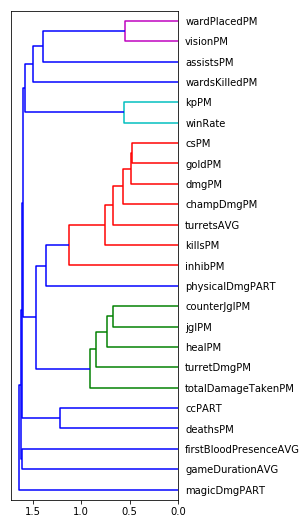

In [6]:
corr = stats.iloc[:, 3:].corr()
f, ax = plt.subplots(figsize=(3, 9))
l = cluster.hierarchy.linkage(corr)
d = cluster.hierarchy.dendrogram(l, labels=corr.columns, orientation="left")

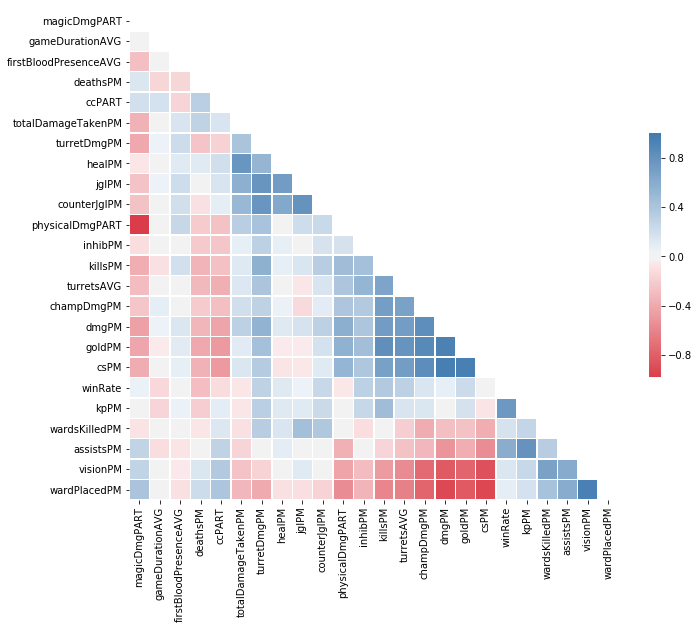

In [7]:
corr = corr.reindex(corr.columns[d["leaves"]]).T.reindex(corr.columns[d["leaves"]])
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 245, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [8]:
stats.sort_values("counterJglPM", ascending=False)[["team", "roleId", "counterJglPM"]].T

name,AHaHaCiK,Tian,Levi,Clid,Lira,Leyan,Canyon,Jankos,Oddie,Crash,Karsa,Svenskeren,Uzi,Shrimp,Xerxe,DNK,Caps,Hana,Tarzan,Doinb,Humanoid,Broxah,Ning,Perkz,Nuguri,Huni,Lloyd,Rockky,Blaber,Licorice,Khan,Faker,Closer,Kobbe,Viper,Nemesis,ShowMaker,Alex,Zeros,JackeyLove,Nuclear,Buggax,Xmithie,DeuL,Warangelus,Sword,Lilv,Evi,Nomanz,Damonte,Steal,Chovy,Cody Sun,Jensen,GimGoon,Doublelift,Langx,FoFo,Innaxe,3Z,Lwx,Teddy,Rekkles,Unified,M1ssion,Wunder,Rookie,Bwipo,Babip,k1ng,Vizicsacsi,Armut,TheShy,Nisqy,Seiya,Xiaohu,Zin,BOSS,brTT,Ceros,Pilot,Robo,Sneaky,Cyeol,Impact,Kiaya,Ming,Rest,Artifact,Rainbow,BeryL,Goku,Lehends,Mikyx,Celebrity,Baolan,Ysera,Luci,Slay,PoP,Gaeng,Wako,Kaiwing,Tolerant,Destiny,Effort,Norskeren,Koala,Hylissang,CoreJJ,Vulcan,Crisp,Edward,G4,Triple,Fudge,Hani,Venus,Slow,Zeyzal,Yutapon,Ziv
team,UOL,FPX,GAM,SKT,CG,IG,DWG,G2,ISG,HKA,RNG,C9,RNG,FLA,SPY,LK,G2,JT,GRF,FPX,SPY,FNC,IG,G2,DWG,CG,MG,MG,C9,C9,SKT,SKT,RYL,SPY,GRF,FNC,DWG,AHQ,GAM,IG,DWG,ISG,TL,MG,ISG,GRF,JT,DFM,UOL,CG,DFM,GRF,CG,TL,FPX,TL,RNG,JT,UOL,HKA,FPX,SKT,FNC,HKA,HKA,G2,IG,FNC,MMM,MMM,SPY,RYL,IG,C9,ISG,RNG,GAM,UOL,FLA,DFM,RYL,FLA,C9,RYL,TL,GAM,RNG,JT,LK,AHQ,DWG,FLA,GRF,G2,LK,IG,AHQ,FLA,GAM,MG,DFM,AHQ,HKA,RYL,MMM,SKT,SPY,JT,FNC,TL,CG,FPX,UOL,MG,MMM,MMM,LK,LK,ISG,C9,DFM,AHQ
roleId,JUN,JUN,JUN,JUN,JUN,JUN,JUN,JUN,JUN,JUN,JUN,JUN,ADC,JUN,JUN,JUN,MID,JUN,JUN,MID,MID,JUN,JUN,ADC,TOP,TOP,JUN,TOP,JUN,TOP,TOP,MID,JUN,ADC,ADC,MID,MID,JUN,TOP,ADC,ADC,TOP,JUN,ADC,ADC,TOP,ADC,TOP,MID,MID,JUN,MID,ADC,MID,TOP,ADC,TOP,MID,ADC,TOP,ADC,ADC,ADC,ADC,MID,TOP,MID,TOP,JUN,ADC,TOP,TOP,TOP,MID,MID,MID,ADC,TOP,ADC,MID,ADC,TOP,ADC,MID,TOP,MID,SUP,TOP,MID,MID,SUP,MID,SUP,SUP,ADC,SUP,SUP,SUP,SUP,SUP,SUP,ADC,SUP,SUP,SUP,SUP,SUP,SUP,SUP,SUP,SUP,SUP,SUP,MID,MID,TOP,TOP,SUP,SUP,SUP,ADC,TOP
counterJglPM,18.9,14.5,14.1667,13.5714,13,12.6667,12.4444,10.9444,10.375,9.9286,9.6667,9.3333,9.1667,8.6,8.1,7.375,7.0556,7,7,7,6.65,6.6,6.4545,6.2222,6.2222,6,5.75,5.75,5.6667,5.5,5.2143,5,4.5,4.35,4.1818,3.9,3.8889,3.8333,3.6667,3.6429,3.5556,3.5,3.5,3.5,3.375,3.3636,3.3333,3.25,3.1,3.0769,3,2.9091,2.8462,2.8333,2.8333,2.8333,2.8333,2.6667,2.6,2.5,2.4444,2.4286,2.4,2.3846,2.2857,2.2222,2.2143,2.2,2.2,2,1.95,1.875,1.7143,1.6667,1.625,1.5,1.3333,1.1,1,1,1,1,0.8,0.75,0.6667,0.6667,0.6667,0.6667,0.625,0.6,0.5,0.4,0.3636,0.2222,0.125,0.0714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


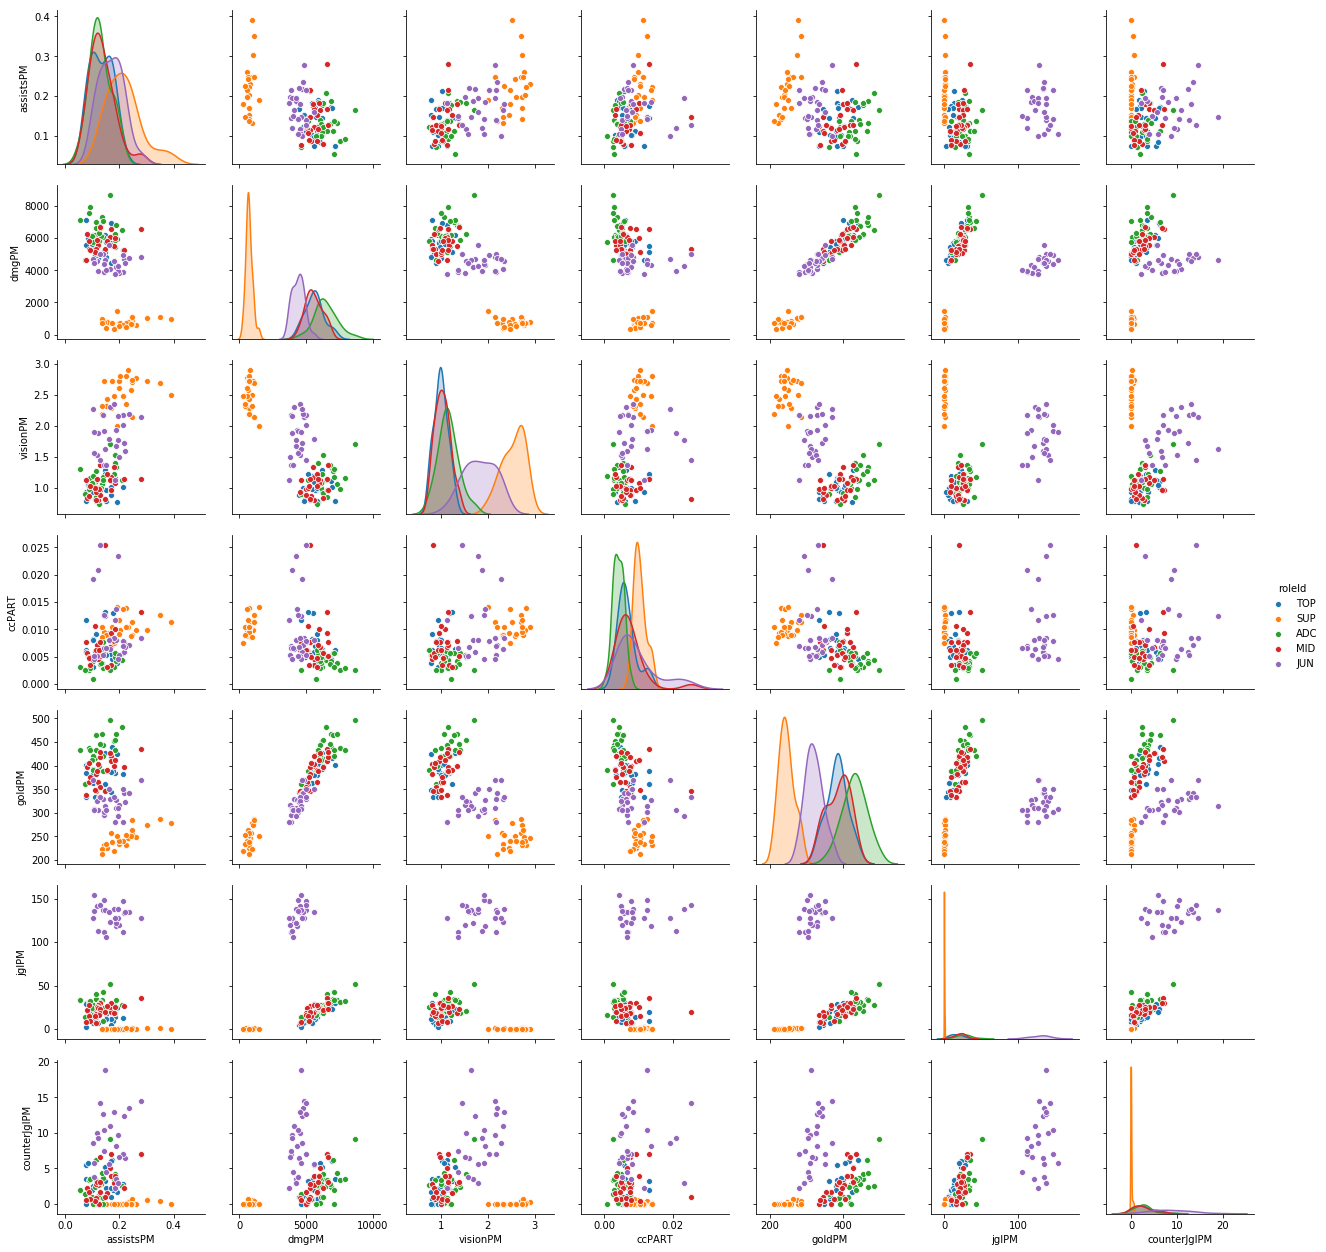

In [9]:
pp = sns.pairplot(stats, vars=["assistsPM", "dmgPM", "visionPM", "ccPART", "goldPM", "jglPM", "counterJglPM"], hue="roleId")

In [10]:
pp.hue_names

['TOP', 'SUP', 'ADC', 'MID', 'JUN']

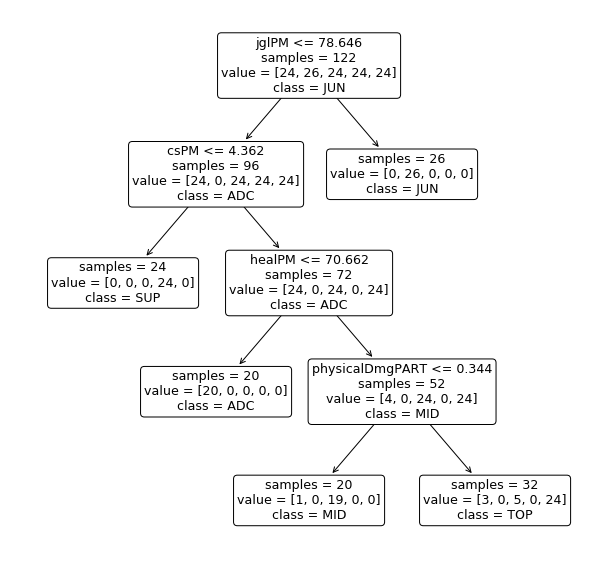

In [11]:
roleTree = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=3)
data = stats.drop(["roleId", "team"], axis=1)
target = stats["roleId"]
roleTree.fit(data, target)
plt.figure(figsize=(10,10))
tree.plot_tree(roleTree, feature_names=data.columns, class_names=roleTree.classes_, impurity=False, rounded=True, rotate=True)
print()

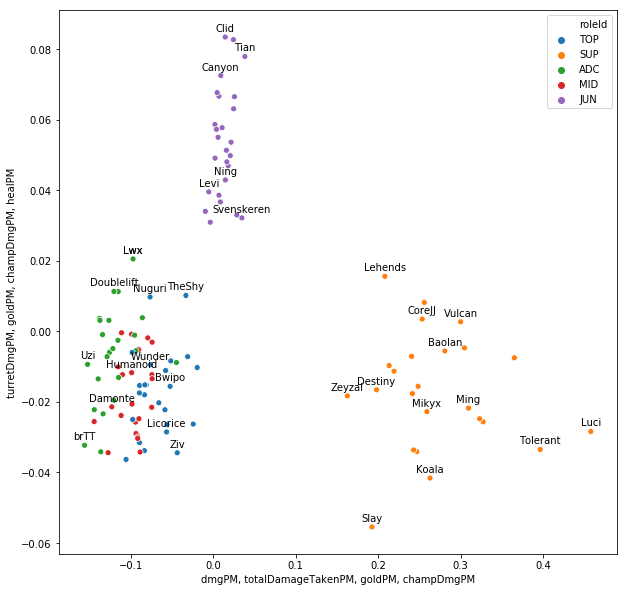

In [12]:
def displayComp(components, cn, sep=", ", amount=2):
    return ", ".join(components.T[cn].apply(lambda x : round(abs(x), 4)).sort_values(ascending=False).head(4).index)

pca = decomposition.PCA(n_components=2)
select = stats.drop(["roleId", "team", "winRate"], axis=1)
data = preprocessing.Normalizer(norm='l1').fit_transform(select)
pca.fit(data)
plt.figure(figsize=(10,10))
components = pd.DataFrame(pca.components_, columns=select.columns)
reduced = pd.DataFrame(pca.transform(data), index=stats.index, columns=[displayComp(components, 0), displayComp(components, 1)])
sc = sns.scatterplot(reduced.iloc[:,0], reduced.iloc[:,1], hue=stats["roleId"])
playersRepresented = ["Clid", "Canyon", "Tian", "Ning", "Svenskeren", "Levi", "Lwx", "Doublelift", "TheShy",
                     "Uzi", "brTT", "Licorice", "Bwipo", "Wunder", "Ziv", "Nuguri", "Lwx", "Damonte", "Humanoid",
                     "Lehends", "Slay", "CoreJJ", "Vulcan", "Luci", "Zeyzal", "Destiny", "Koala", "Baolan", "Mikyx",
                     "Tolerant", "Ming"]
for i, r in reduced.T[playersRepresented].T.iterrows():
    sc.text(*(r+(0,0.001)), i, horizontalalignment='center', verticalalignment='bottom', size='medium', color='black')


In [13]:
pd.DataFrame(pca.components_, columns=select.columns)

,gamesPlayed,gameDurationAVG,killsPM,deathsPM,assistsPM,kpPM,dmgPM,turretDmgPM,champDmgPM,magicDmgPART,physicalDmgPART,healPM,visionPM,ccPART,goldPM,totalDamageTakenPM,turretsAVG,inhibPM,csPM,jglPM,counterJglPM,wardPlacedPM,wardsKilledPM,firstBloodPresenceAVG
0,0.011474,0.042304,0.000009,0.000132,0.000289,0.000299,-0.877103,0.007707,0.089697,0.000943,0.00011,0.084510,0.003690,0.000014,0.252815,0.386733,-0.000109,5.039388e-07,-0.001184,-0.004697,-0.000588,0.002364,0.000517,0.000073
1,-0.008189,-0.052710,-0.000003,-0.000196,-0.000230,-0.000233,-0.221509,0.747771,-0.279233,-0.001346,-0.00009,0.242499,-0.003396,-0.000014,-0.390662,-0.241596,-0.000168,4.241121e-07,-0.003655,0.202365,0.013413,-0.002517,-0.000307,0.000006
